<h1>DESIGN OF PI CONTROLLER IN DISCRETE TIME</h1>

<p>Main purpose is to analyze how to use simple PI controller in discrete time.</p>

<p>The fundamental question is to understand how the knowledge from continuous time can be used also in this discrete time case.</p>

<p>We will first review the design process in continuous time and then we see how this transfer to discrete time</p>

<h2>System definition</h2>

<p>As a first step let us define the system in continuous time domain</p>

<p>For sake of simplicity we consider a system with two poles and no zeros.</p>

<p>You can play with the values of p1 and p2 to try different systems.</p>

In [1]:
% Set the Octave Engine to run the simulation
SetSimulationEnvironment;

p1 = -5;
p2 = -8;

Num = [p1*p2];
Den = [1 -(p1+p2) p1*p2];

Gs = tf(Num,Den)


Transfer function 'Gs' from input 'u1' to output ...

            40       
 y1:  ---------------
      s^2 + 13 s + 40

Continuous-time model.


<h2>PID design continuous-time</h2>

<p>Let us review some fundamentals of continuous time systems</p>

<p>Given that the system has two poles and no zeros, a PID controller allows the design of a controller with high robustness</p>

<p>We select the coefficients so to cancel the poles of the system and then we set Kp to define the bandwidth.</p>

In [2]:
omo = 20;
Kd1 = omo/(p1*p2);
Kp1 = Kd1*(-(p1+p2));
Ki1 = Kd1*p1*p2;

GrNum = [Kd1 Kp1 Ki1];
GrDen = [1 0];

Gr = tf(GrNum,GrDen);

<p>We can now plot the frequency response of the plant</p>

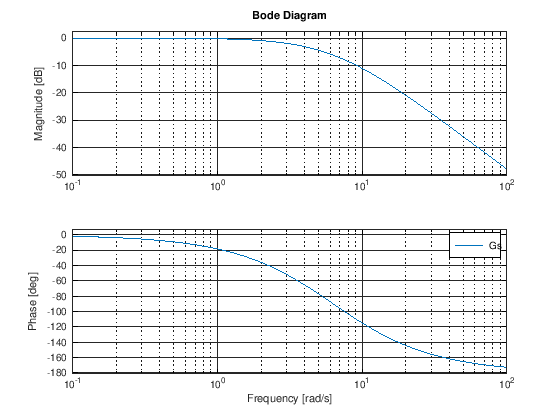

In [3]:
bode(Gs)

<p>and the frequency response of the open loop.</p>
<p>Notice thanks to this design approach we cross 0dB with 20dB/decade and then phase margin is 90 degrees. The system is really robust</p>

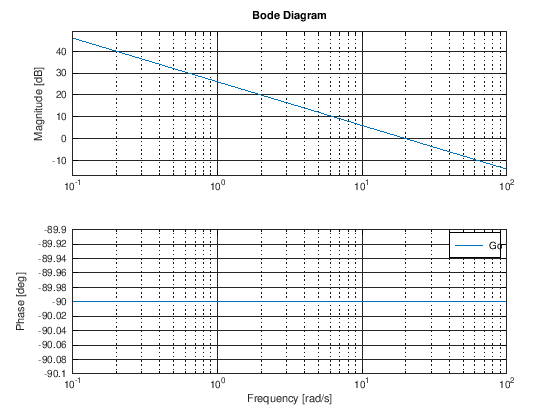

In [4]:
Go = Gs*Gr;
bode(Go)

<p>To check the performance a step response of the closed-loop is then calculated</p>
<p>Notice that because of the high margin there is no overshoot</p>

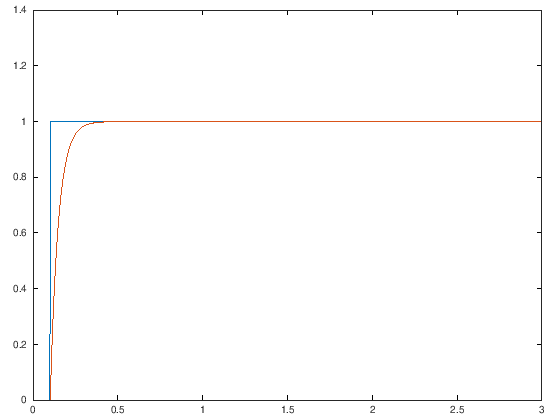

In [5]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 3;
% Time Step
dt = 0.001;
% Number of data flows in the schematic
nflows = 4;
% Sampling time for discrete time
Ts = 0.01;

% Instance of the simulation schematic
sc1 = Schema(tini,tfinal,dt,nflows);

% List of components
c1{1} = StepSource(1,0,1,0.1);
c1{2} = Sum(1,2,3,1,-1);
c1{3} = PID(3,4,Kp1,Ki1,Kd1,0);
c1{4} = TransferFunction(4,2,Num,Den);


sc1.AddListComponents(c1);

% Run the schematic and plot
out1 = sc1.Run([1 2]);
plot(out1(1,:),out1(2,:),out1(1,:),out1(3,:));

<h2>PI Control in continuous-time</h2>
<p>In many real applications though the derivative term is not practical given the possible noise in the measurement channel</p>
<p>For this reason a PI control is preferred</p>
<p>In this case we can define the open loop crossing frequency and the relative phase margin</p>
<p>You can play here with these parameters to try different controllers</p>

In [12]:
omo = 10;
Fideg = 50;
Fi = Fideg*pi/180;

[Go Fo]= bode(Gs,omo)
Fo = Fo*pi/180;

Kp2 = cos(-pi+Fi-Fo)/Go
Ki2 = -sin(-pi+Fi-Fo)*omo/Go


Go =  0.27937
Fo = -114.78
Kp2 =  3.4538
Ki2 =  9.3999


<p>To check the design we can calculate with the function margin the characteristics of the open loop.</p>
<p>We expect to find exactly the value as from the specifications</p>


Transfer function 'Gr2' from input 'u1' to output ...

      3.454 s + 9.4
 y1:  -------------
            s      

Continuous-time model.


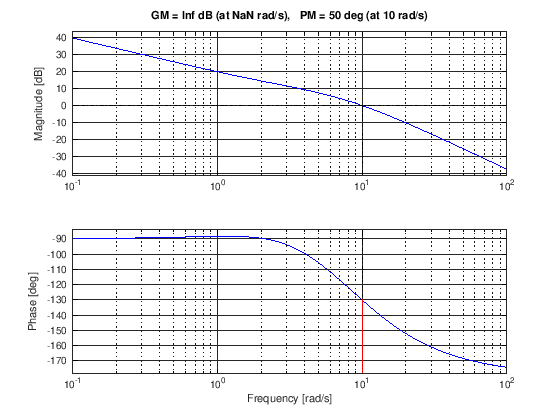

In [13]:
NumGr2 = [Kp2 Ki2];
DenGr2 = [1 0];
Gr2 = tf(NumGr2,DenGr2)
Go2 = Gs*Gr2;
margin(Go2)

<p>As before we perform now a step response of the closed loop system</p>
<p>Given that now the phase margin is lower than 90 degress, we expect correspondingly an overshoot</p>

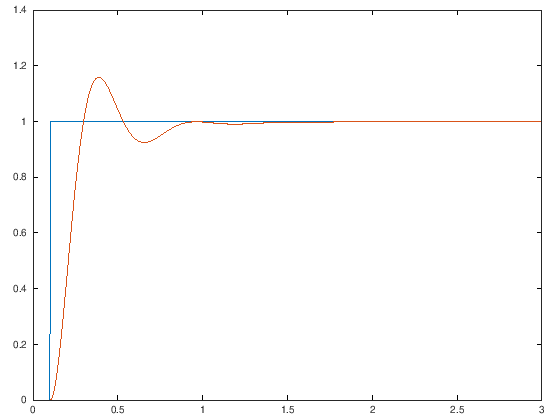

In [14]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 3;
% Time Step
dt = 0.001;
% Number of data flows in the schematic
nflows = 4;
% Sampling time for discrete time
Ts = 0.01;

% Instance of the simulation schematic
sc2 = Schema(tini,tfinal,dt,nflows);

% List of components
c2{1} = StepSource(1,0,1,0.1);
c2{2} = Sum(1,2,3,1,-1);
c2{3} = PI(3,4,Kp2,Ki2,0);
c2{4} = TransferFunction(4,2,Num,Den);


sc2.AddListComponents(c2);

% Run the schematic and plot
out2 = sc2.Run([1 2]);
plot(out2(1,:),out2(2,:),out2(1,:),out2(3,:));

<h2>PI Design in discrete-time</h2>
<p>We explore now how the design in continuous time can be extended to discrete-time.</p>
<p>We will consider different options</p>
<h3>Direct application of the design in continuous time</h3>
<p>As first approach we take the values of PI from the continuous time domain and we use them directly in discrete time</p>
<p>We adapt the formula to the discrete time domain discretizing the integrator in the z-domain</p>

In [16]:
Ts = 0.02;
Kr = Kp2;
Ti = Kr/Ki2;

Zn = 1/(1+Ts/Ti);

Numrz = [Kr/Zn -Kr];
Denrz = [1 -1];

<p>We obtain the corresponding new transfer function in the z domain.</p>
<p>If we calculate margin we will find that we have lost margin because of the presence of the ZOH and sampler</p>


Transfer function 'Grz' from input 'u1' to output ...

      3.642 z - 3.454
 y1:  ---------------
           z - 1     

Sampling time: 0.02 s
Discrete-time model.

Transfer function 'Gsz' from input 'u1' to output ...

       0.00734 z + 0.006731 
 y1:  ----------------------
      z^2 - 1.757 z + 0.7711

Sampling time: 0.02 s
Discrete-time model.


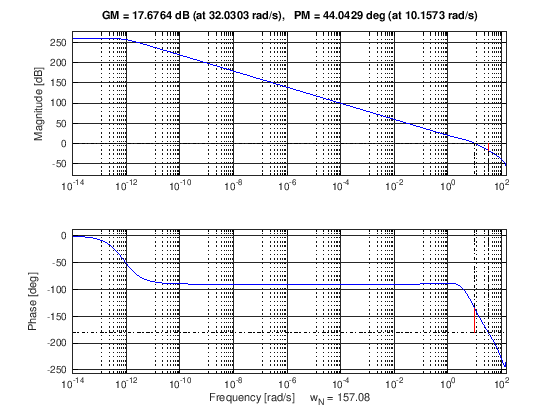

In [17]:
Grz = tf(Numrz,Denrz,Ts)
Gsz = c2d(Gs,Ts,'zoh')

Go3 = Grz*Gsz;
margin(Go3)

<p>The amount of phase margin that we lost can be calculated with this simple formula.</p>

In [18]:
DeltaFim = (omo*Ts/2)*180/pi

DeltaFim =  5.7296


<p>A simulation of a step response confirms that we have a higher overshoot</p>

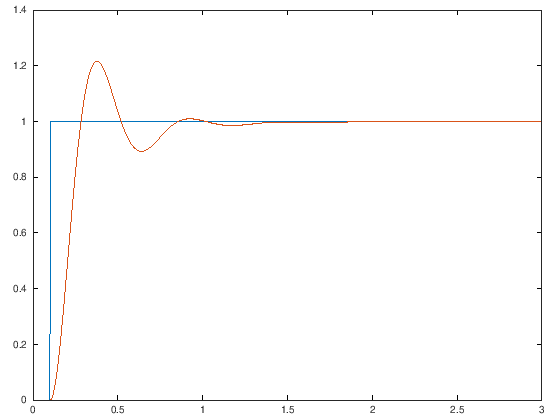

In [19]:
% Number of data flows in the schematic
nflows = 4;

% Instance of the simulation schematic
sc3 = Schema(tini,tfinal,dt,nflows);

% List of components
c3{1} = StepSource(1,0,1,0.1);
c3{2} = Sum(1,2,3,1,-1);
c3{3} = DTTransferFunction(3,4,Numrz,Denrz,Ts);
c3{4} = TransferFunction(4,2,Num,Den);


sc3.AddListComponents(c3);

% Run the schematic and plot
out3 = sc3.Run([1 2]);
plot(out3(1,:),out3(2,:),out3(1,:),out3(3,:));

<h3>A priori compensation</h3>
<p>An easy way to overcome the problem is to design in continous-time precompensating the amount of phase margin that we lose requesting a PI with a larger Phase margine</p>


In [20]:
omo = 10;
Fideg = 50;
Fi2 = (Fideg+DeltaFim)*pi/180;

[Go2 Fo2]= bode(Gs,omo)
Fo2 = Fo2*pi/180;

Kp3 = cos(-pi+Fi2-Fo2)/Go2
Ki3 = -sin(-pi+Fi2-Fo2)*omo/Go2

Ts = 0.02;
Kr2 = Kp3;
Ti2 = Kr2/Ki3;

Zn2 = 1/(1+Ts/Ti2);

Numrz2 = [Kr2/Zn2 -Kr2];
Denrz2 = [1 -1];

Go2 =  0.27937
Fo2 = -114.78
Kp3 =  3.5304
Ki3 =  5.9049


<p>If we now check margin, we will find the original value used for the first specificnation in continuous time</p>


Transfer function 'Grz2' from input 'u1' to output ...

      3.649 z - 3.53
 y1:  --------------
          z - 1     

Sampling time: 0.02 s
Discrete-time model.


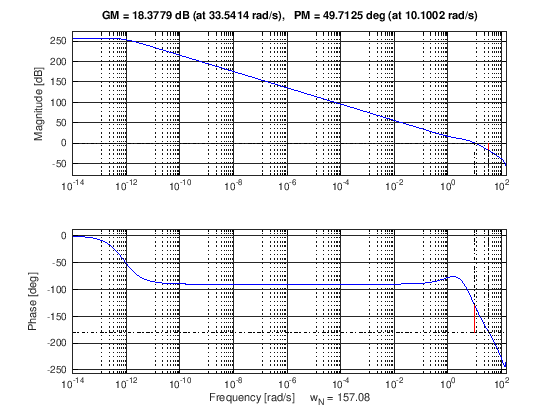

In [21]:
Grz2 = tf(Numrz2,Denrz2,Ts)

Go4 = Grz2*Gsz;
margin(Go4)

<p>A step response confirms the result and we get the same overshoot of the continuous time controller</p>

In [22]:
% Number of data flows in the schematic
nflows = 4;

% Instance of the simulation schematic
sc4 = Schema(tini,tfinal,dt,nflows);

% List of components
c4{1} = StepSource(1,0,1,0.1);
c4{2} = Sum(1,2,3,1,-1);
c4{3} = DTTransferFunction(3,4,Numrz2,Denrz2,Ts);
c4{4} = TransferFunction(4,2,Num,Den);


sc4.AddListComponents(c4);

% Run the schematic and plot
out4 = sc4.Run([1 2]);
plot(out4(1,:),out4(2,:),out4(1,:),out4(3,:));

<h3>Direct design in the z domain</h3>
<p>Another option clearly is to repeat the process in the domain as done for the s-domain</p>
<p>Also in this case the problem is formulated as an algebraic problem with a system of two equations with two unknowns</p>
<p>Formulas are not so straightforward as in continuous time domain but they can be anyway analytically calculated</p>

In [24]:
omo = 10;
Fi = 50*pi/180;

[God Fod]= bode(Gsz,omo)
Fod = Fod*pi/180;

gamma =  -pi+Fi-Fod;
b = exp(1j*gamma)*(exp(1j*omo*Ts)-1)/God

A = [cos(omo*Ts) -1;sin(omo*Ts) 0];
x = inv(A)*[real(b); imag(b)];

Kp4 = x(2)
Zn3 = Kp4/x(1)
Kr3 = Kp4;

Numrz3 = [Kr3/Zn3 -Kr3];
Denrz3 = [1 -1];
Grz3 = tf(Numrz3,Denrz3,Ts)

God =  0.27891
Fod = -120.50
b =  0.047025 + 0.714345i
Kp4 =  3.4770
Zn3 =  0.96699

Transfer function 'Grz3' from input 'u1' to output ...

      3.596 z - 3.477
 y1:  ---------------
           z - 1     

Sampling time: 0.02 s
Discrete-time model.


<p>In this case the phase margin is the same as in the original specification</p>

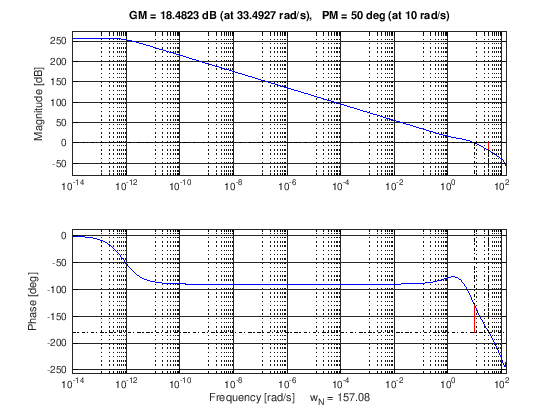

In [25]:
Go5 = Grz3*Gsz;
margin(Go5)

<p>A step response confirms again the result</p>

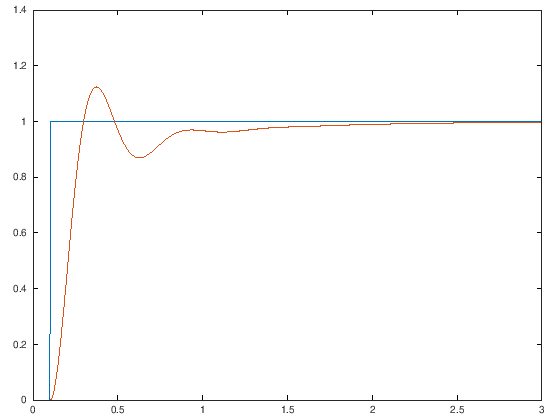

In [26]:
% Number of data flows in the schematic
nflows = 4;

% Instance of the simulation schematic
sc5 = Schema(tini,tfinal,dt,nflows);

% List of components
c5{1} = StepSource(1,0,1,0.1);
c5{2} = Sum(1,2,3,1,-1);
c5{3} = DTTransferFunction(3,4,Numrz3,Denrz3,Ts);
c5{4} = TransferFunction(4,2,Num,Den);


sc5.AddListComponents(c5);

% Run the schematic and plot
out5 = sc5.Run([1 2]);
plot(out5(1,:),out5(2,:),out5(1,:),out5(3,:));